Neste notebook faremos uma análise exploratória dos dados pré-processados da Wyscout, em seguida treinaremos modelos de classificação para prever o xG.

In [33]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mplsoccer import VerticalPitch
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#other
import aux_functions_plot as p

#ml / stats

import sklearn.metrics as sk_metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout



## Modelagem

In [2]:
shots = pd.read_csv('./data/shots_dataframe_modelling.csv')

In [3]:
features = ['y', 'c', 'distance', 'angle',
       'free_kick', 'counter_attack', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'prev_duel'] # removemos x da lista de features devido à análise de multicolinearidade feita anteriormente

baseline_features = ['distance', 'angle']

target = ['goal']

In [4]:
X = shots[features]
X_baseline = shots[baseline_features]
y = shots[target]

Separando os dados em treino / teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y, test_size=0.25, random_state=42)

In [6]:
len(y_test_baseline['goal'])

11316

In [7]:
y_test_baseline['goal'].sum()

1172

### Modelo baseline - Regressão Logística

In [8]:
lr_baseline = LogisticRegression(random_state=42)
lr_baseline.fit(X_train_baseline, np.array(y_train_baseline).ravel())

LogisticRegression(random_state=42)

In [9]:
pred_vals_baseline = lr_baseline.predict(X_test_baseline)

In [10]:
for i, col in enumerate(X_train_baseline.columns):
    print(f"Coeficiente da feature {col}: {lr_baseline.coef_[0][i]:.3f}")

Coeficiente da feature distance: -0.088
Coeficiente da feature angle: 1.373


In [11]:
pred_probs = lr_baseline.predict_proba(X_test_baseline)[:,1]
print(f"Log loss do modelo: {sk_metrics.log_loss(y_test_baseline, pred_probs):.5f}")
print(f"AUC do modelo: {sk_metrics.roc_auc_score(y_test_baseline, pred_probs)*100:.2f}%")

Log loss do modelo: 0.28693
AUC do modelo: 76.59%


In [12]:
# A titulo de comparação, caso tenhamos usado apenas a média para fazer a predição, a log-loss seria:

print(f"Log loss da média (0.1017, calculado anteriormente): {sk_metrics.log_loss(y_test, [0.1017]*len(y_test_baseline)):.3f}")

Log loss da média (0.1017, calculado anteriormente): 0.333


Nosso baseline é melhor do que usar a média para prever, o que é bom. Vamos agora usar validação cruzada e todas as features

### Regressão Logística - Testando todas as features + Scaling + CV

In [13]:
# Separando o dataset de treino em treino e validação para cross-validation
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [15]:
lr = LogisticRegression(max_iter = 1000, random_state=42)

scaler = MinMaxScaler()

X_t_scaled = scaler.fit_transform(X_t)
X_val_scaled = scaler.fit_transform(X_val)

param_grid = {
                 'C': [0.3,0.5,0.8,1.0],
                 'solver': ['newton-cholesky', 'lbfgs'],
            }

grid_rf = GridSearchCV(lr, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_rf.fit(X_t_scaled, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_rf.predict_proba(X_t_scaled))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_rf.predict_proba(X_val_scaled))}")

print("\n")

print(f"Best parameters were:{grid_rf.best_params_}")

Training log-loss:0.2751922742734204


Validation log-loss: 0.2886638655357784


Best parameters were:{'C': 1.0, 'solver': 'newton-cholesky'}


Não parece haver overfitting, dado que o resultado de treino e validação são similares. Vamos ver o desempenho no hold-out.

In [16]:
X_train_scaled = scaler.fit_transform(X_train)
lr.fit(X_train_scaled, np.array(y_train).ravel())

LogisticRegression(max_iter=1000, random_state=42)

In [17]:
pred_vals_allfeatures = lr.predict(X_test)

In [18]:
X_test_scaled = scaler.fit_transform(X_test)
pred_probs = lr.predict_proba(X_test_scaled)[:,1]
print(f"Log loss do modelo: {sk_metrics.log_loss(y_test, pred_probs):.5f}")
print(f"AUC do modelo: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")

Log loss do modelo: 0.28120
AUC do modelo: 77.93%


In [19]:
for i, col in enumerate(X_train.columns):
    print(f"Coeficiente da feature {col}: {lr.coef_[0][i]:.3f}")

Coeficiente da feature y: -0.221
Coeficiente da feature c: -0.315
Coeficiente da feature distance: -8.782
Coeficiente da feature angle: 4.644
Coeficiente da feature free_kick: 0.717
Coeficiente da feature counter_attack: 0.641
Coeficiente da feature rebound: 0.299
Coeficiente da feature prev_cross: -0.378
Coeficiente da feature prev_touch: 0.031
Coeficiente da feature prev_pass: -0.024
Coeficiente da feature prev_smart_pass: 0.403
Coeficiente da feature prev_duel: -0.442


### Random Forest

In [57]:
rf = RandomForestClassifier(criterion="log_loss")

param_grid = {
                 'n_estimators': [30,40,60],
                 'max_depth': [4,5,6,7,8,9,10],
                 'min_samples_split': [2,4,6,8]
            }

grid_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_rf.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_rf.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_rf.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_rf.best_params_}")

Training log-loss:0.2652748645488553


Validation log-loss: 0.28779839439772237


Best parameters were:{'max_depth': 7, 'min_samples_split': 8, 'n_estimators': 60}


In [58]:
rf = RandomForestClassifier(max_depth=7, min_samples_split=4, n_estimators=60, criterion="log_loss")
rf.fit(X_train, np.array(y_train).ravel())

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_split=4,
                       n_estimators=60)

In [59]:
pred_probs_rf = rf.predict_proba(X_test)[:,1]
print(f"Log loss da Random Forest: {sk_metrics.log_loss(y_test, pred_probs_rf):.5f}")
print(f"AUC da Random Forest: {sk_metrics.roc_auc_score(y_test, pred_probs_rf)*100:.2f}%")

Log loss da Random Forest: 0.28084
AUC da Random Forest: 78.21%


In [60]:
start_time = time.time()
result = permutation_importance(
    rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Tempo para computar as feature importances usando permutação: {elapsed_time:.3f} segundos")

forest_importances = pd.Series(result.importances_mean, index=features)

Tempo para computar as feature importances usando permutação: 1.886 segundos


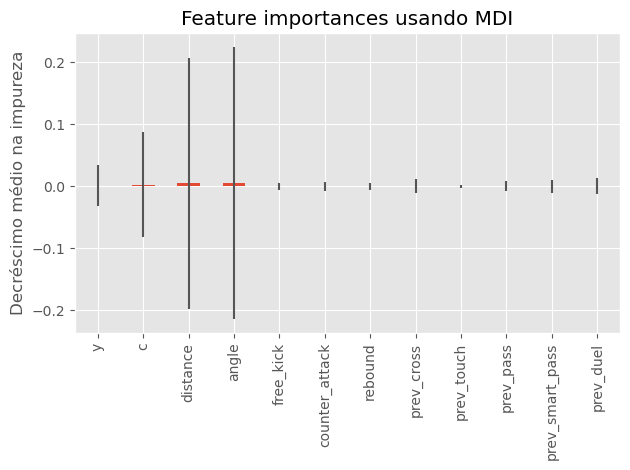

In [61]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances usando MDI")
ax.set_ylabel("Decréscimo médio na impureza")
fig.tight_layout()

### XGBoost Classifier

In [24]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [20,50,100, 200, 300],  
    'learning_rate': [0.05, 0.1, 0.3],  
    'max_depth': [3,6,9], 
    'colsample_bytree': [0.5, 1.0] 
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

grid_xgb = GridSearchCV(xgb_classifier, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_xgb.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_xgb.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_xgb.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_xgb.best_params_}")


Training log-loss:0.2689153770367763


Validation log-loss: 0.2861990675224161


Best parameters were:{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


### Light GBM

In [23]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [14 ,31, 63, 127],
    'n_estimators': [20,50,100, 200, 300]
}

# Create the XGBoost classifier
lgb_classifier = lgb.LGBMClassifier()

grid_lgb = GridSearchCV(lgb_classifier, param_grid, cv=5, n_jobs = -1, scoring = 'neg_log_loss')
grid_lgb.fit(X_t, np.array(y_t).ravel())

print(f"Training log-loss:{sk_metrics.log_loss(y_t, grid_lgb.predict_proba(X_t))}")

print("\n")

print(f"Validation log-loss: {sk_metrics.log_loss(y_val, grid_lgb.predict_proba(X_val))}")

print("\n")

print(f"Best parameters were:{grid_lgb.best_params_}")


Training log-loss:0.27084880392850735


Validation log-loss: 0.2860316227405863


Best parameters were:{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 14}


### LSTM

In [30]:
# Reshape and adjust data type
X_t_lstm = X_t.values.reshape(X_t.shape[0], X_t.shape[1], 1).astype('float32')
X_val_lstm = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1).astype('float32')
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=4))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dense(units=1))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 7s 4ms/step - loss: 0.3356 - binary_crossentropy: 0.3356 - val_loss: 0.2986 - val_binary_crossentropy: 0.2986
Epoch 2/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2868 - binary_crossentropy: 0.2868 - val_loss: 0.3014 - val_binary_crossentropy: 0.3014
Epoch 3/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2853 - binary_crossentropy: 0.2853 - val_loss: 0.2972 - val_binary_crossentropy: 0.2972
Epoch 4/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2847 - binary_crossentropy: 0.2847 - val_loss: 0.2963 - val_binary_crossentropy: 0.2963
Epoch 5/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2837 - binary_crossentropy: 0.2837 - val_loss: 0.2986 - val_binary_crossentropy: 0.2986
Epoch 6/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2839 - binary_crossentropy: 0.2839 - val_loss: 0.2952 - val_binary_crossentropy: 0.2952
Epoch 7/10
743/7

In [31]:
# Reshape and adjust data type
X_t_lstm = X_t.values.reshape(X_t.shape[0], X_t.shape[1], 1).astype('float32')
X_val_lstm = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1).astype('float32')
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=8))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dense(units=2))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 5s 4ms/step - loss: 0.3270 - binary_crossentropy: 0.3270 - val_loss: 0.2955 - val_binary_crossentropy: 0.2955
Epoch 2/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2841 - binary_crossentropy: 0.2841 - val_loss: 0.2992 - val_binary_crossentropy: 0.2992
Epoch 3/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2837 - binary_crossentropy: 0.2837 - val_loss: 0.2956 - val_binary_crossentropy: 0.2956
Epoch 4/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2827 - binary_crossentropy: 0.2827 - val_loss: 0.2925 - val_binary_crossentropy: 0.2925
Epoch 5/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2819 - binary_crossentropy: 0.2819 - val_loss: 0.2920 - val_binary_crossentropy: 0.2920
Epoch 6/10
743/743 [==============================] - 2s 3ms/step - loss: 0.2808 - binary_crossentropy: 0.2808 - val_loss: 0.2913 - val_binary_crossentropy: 0.2913
Epoch 7/10
743/7

In [35]:
# Reshape and adjust data type
X_t_lstm = X_t.values.reshape(X_t.shape[0], X_t.shape[1], 1).astype('float32')
X_val_lstm = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1).astype('float32')
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=12))  # Specify the number of LSTM units/neurons
# Add any additional LSTM layers, if needed
model.add(Dropout(0.2))
model.add(Dense(units=4))  # Specify the number of units in the dense layer
# Add any additional dense layers, if needed
model.add(Dense(units=1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

# Train the model
model.fit(X_t_lstm, y_t, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))

# Evaluate the model on test data
loss, log_loss_test = model.evaluate(X_test_lstm, y_test)

print(f"Log loss of the test dataset is: {log_loss_test}")


Epoch 1/10
743/743 [==============================] - 5s 5ms/step - loss: 0.3158 - binary_crossentropy: 0.3158 - val_loss: 0.2950 - val_binary_crossentropy: 0.2950
Epoch 2/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2871 - binary_crossentropy: 0.2871 - val_loss: 0.2955 - val_binary_crossentropy: 0.2955
Epoch 3/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2866 - binary_crossentropy: 0.2866 - val_loss: 0.2975 - val_binary_crossentropy: 0.2975
Epoch 4/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2853 - binary_crossentropy: 0.2853 - val_loss: 0.2983 - val_binary_crossentropy: 0.2983
Epoch 5/10
743/743 [==============================] - 3s 4ms/step - loss: 0.2847 - binary_crossentropy: 0.2847 - val_loss: 0.2945 - val_binary_crossentropy: 0.2945
Epoch 6/10
743/743 [==============================] - 3s 3ms/step - loss: 0.2846 - binary_crossentropy: 0.2846 - val_loss: 0.2923 - val_binary_crossentropy: 0.2923
Epoch 7/10
743/7